# 1. Preparação do notebook

In [1]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 8.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from google.colab import files
from scipy.stats import mstats                                      # para winsorização
from statsmodels.nonparametric.kernel_regression import KernelReg   # para suavização por kernel
from statsmodels.tsa.holtwinters import SimpleExpSmoothing          # para suavização exponencial simples
from statsmodels.tsa.holtwinters import Holt                        # para suavização exponencial quadrática
from scipy.interpolate import UnivariateSpline                      # para smoothing splines
from statsmodels.nonparametric.smoothers_lowess import lowess       # para lowess smoothing
from statsmodels.tsa.filters.hp_filter import hpfilter              # para filtro hidrick-prescott
from pykalman import KalmanFilter                                   # para filtro de kalman
import warnings
import matplotlib.pyplot as plt

In [3]:
# Oculta avisos específicos do NumPy
warnings.filterwarnings("ignore", category=UserWarning, module="numpy")

# 2. Leitura dos dados

In [4]:
# Abertura da caixa de diálogo para selecionar o arquivo
uploaded = files.upload()

# Obtenção do nome do arquivo selecionado
filename = list(uploaded.keys())[0]

# Leitura do arquivo para um DataFrame
df = pd.read_excel(filename)

df.head()

Saving [BM Regime Switching] Geração de séries temporais.xlsx to [BM Regime Switching] Geração de séries temporais.xlsx


,regime_switching_1,regime_switching_2,regime_switching_3,regime_switching_4,regime_switching_5,regime_switching_6,regime_switching_7,regime_switching_8,regime_switching_9,regime_switching_10
0,-1.687820,-0.283843,0.126658,0.377150,-0.765880,-1.355139,0.669358,-0.694463,0.065922,-0.314608
1,-1.229467,-0.365411,-0.123630,1.177021,258.615483,297.220884,0.814437,-1.024517,0.234078,-0.685179
2,-0.830905,-0.084121,-0.025177,0.623488,-0.997694,-0.039636,0.272728,216.373252,-0.571165,-1.355646
3,0.664868,-0.326946,-0.096295,0.768356,-1.361355,-0.040746,0.740739,217.235444,-0.337167,-1.355416
4,-0.226449,0.679964,-0.601503,0.572884,-2.230610,-0.282606,0.954610,-0.636281,-0.023799,-1.782896


In [5]:
df = df[['regime_switching_1']]
df.head()

,regime_switching_1
0,-1.687820
1,-1.229467
2,-0.830905
3,0.664868
4,-0.226449


# 3. Aplicação dos métodos de tratamento

In [6]:
# Winsorização
def winsorize_series(series, limits=[0.05, 0.05]):
    series = series.copy()  # Evita alterar a série original
    series_filled = series.fillna(series.median())  # Substituir NaN pela mediana

    winsorized_values = mstats.winsorize(series_filled, limits=limits)

    return pd.Series(winsorized_values, index=series.index)

# Médias Móveis
def moving_average(series, window=5):
    return series.rolling(window=window).mean()

# Suavização por Kernel
def kernel_smoothing(series, bandwidth=1):
    series = series.dropna()  # Remover valores ausentes
    x = np.arange(len(series))
    kr = KernelReg(series, x, 'c', reg_type='ll', bw=[bandwidth])

    smoothed_values = kr.fit()[0]  # Ajuste do Kernel
    return pd.Series(smoothed_values, index=series.index)

# Suavização Exponencial Simples
def simple_exponential_smoothing(series, alpha=0.3):
    series = series.fillna(method="ffill")  # Preenchendo valores ausentes

    model = SimpleExpSmoothing(series)
    fit = model.fit(smoothing_level=alpha, optimized=False)

    return pd.Series(fit.fittedvalues, index=series.index)

# Suavuzação Exponencial Quadrática
def holts_linear_trend(series, alpha=0.3, beta=0.1):
    series = series.fillna(method="ffill")  # Preenchendo valores ausentes

    model = Holt(series)
    fit = model.fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False)

    return pd.Series(fit.fittedvalues, index=series.index)

# Smoothing Splines
def smoothing_splines(series, s=0.1):
    series = series.dropna()  # Remover valores NaN antes de processar

    # Criar um spline apenas para os valores não nulos
    x = np.arange(len(series))
    y = series.values
    spl = UnivariateSpline(x, y, s=s)

    # Preencher os valores suavizados
    smoothed_values = spl(x)

    # Retornar uma série no formato original (preservando índices)
    return pd.Series(smoothed_values, index=series.index)

# Lowess Smoothing
def lowess_smoothing(series, frac=0.1):
    series = series.dropna()  # Remover valores NaN antes de processar

    x = np.arange(len(series))
    smoothed = lowess(series, x, frac=frac, return_sorted=False)

    # Retornar como pandas Series mantendo o mesmo índice original
    return pd.Series(smoothed, index=series.index)

# Filtro Recursivo
def recursive_filter(series, alpha=0.3):
    series = series.fillna(method="ffill")  # Preenchendo valores ausentes

    result = [series.iloc[0]]
    for i in range(1, len(series)):
        result.append(alpha * series.iloc[i] + (1 - alpha) * result[i-1])

    return pd.Series(result, index=series.index)

# Filtro Hodick-Prescott
def hodrick_prescott_filter(series, lamb=13322500):
    series = series.dropna()  # Remover valores ausentes

    cycle, trend = hpfilter(series, lamb=lamb)
    return pd.Series(trend, index=series.index)

# Filtro de Kalman
def kalman_filter(series):
    series = series.fillna(method="ffill")  # Preenchendo valores ausentes

    kf = KalmanFilter(initial_state_mean=series.iloc[0], n_dim_obs=1)
    filtered_state_means, _ = kf.filter(series.values)

    return pd.Series(filtered_state_means.flatten(), index=series.index)

## 3.1. Divisão das séries em conjunto de treino (70%) e de teste (30%)

In [7]:
# Definindo o índice de corte (80% para treino)
train_size = int(len(df) * 0.7)

# Separando treino e teste
df_train = df.iloc[:train_size, :]
df_test = df.iloc[train_size:, :]

df_train.head()

,regime_switching_1
0,-1.687820
1,-1.229467
2,-0.830905
3,0.664868
4,-0.226449


In [8]:
# Tamanho do conjunto de treino
n = len(df_train)
n

4160

In [9]:
df.columns

Index(['regime_switching_1'], dtype='object')

In [10]:
################################
##### Detecção de outliers #####
################################

# Função para calcular o percentual de outliers usando o método IQR
def calcular_percentual_outliers(series):
    q1 = np.percentile(series, 25)
    q3 = np.percentile(series, 75)
    iqr = q3 - q1
    lim_inf = q1 - 1.5 * iqr
    lim_sup = q3 + 1.5 * iqr
    outliers = (series < lim_inf) | (series > lim_sup)
    return np.mean(outliers) * 100

# Calcular o percentual de outliers para cada série
percentuais_outliers = calcular_percentual_outliers(df_train)
print(f"Porcentagem de outliers: {percentuais_outliers:.2f}%")

Porcentagem de outliers: 4.95%


## 3.2. Aplicação dos métodos de tratamento de outliers

In [11]:
methods = {
    'W': winsorize_series,
    'MA': moving_average,
    'KS': kernel_smoothing,
    'SES': simple_exponential_smoothing,
    'QES': holts_linear_trend,
    'SPLINES': smoothing_splines,
    'LOWESS': lowess_smoothing,
    'RF': recursive_filter,
    'HP': hodrick_prescott_filter,
    'KALMAN': kalman_filter
}

# Criar um DataFrame para armazenar os resultados
df_processed = pd.DataFrame(index=df_train.index)

# Definir a coluna específica que será processada
coluna_alvo = coluna_alvo = df_train.columns[0]

# Aplicação dos métodos e adicionando ao DataFrame processado
for method_name, method_func in methods.items():
    df_processed[f'{coluna_alvo}_{method_name}'] = method_func(df_train[coluna_alvo])

# Resetar o índice para incluir a coluna 'Date' novamente
df_processed = df_processed.reset_index()

df_processed.head()

<ipython-input-6-e03f29328a2c>:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.fillna(method="ffill")  # Preenchendo valores ausentes
<ipython-input-6-e03f29328a2c>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.fillna(method="ffill")  # Preenchendo valores ausentes
<ipython-input-6-e03f29328a2c>:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.fillna(method="ffill")  # Preenchendo valores ausentes
<ipython-input-6-e03f29328a2c>:85: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.fillna(method="ffill")  # Preenchendo valores ausentes


,index,regime_switching_1_W,regime_switching_1_MA,regime_switching_1_KS,regime_switching_1_SES,regime_switching_1_QES,regime_switching_1_SPLINES,regime_switching_1_LOWESS,regime_switching_1_RF,regime_switching_1_HP,regime_switching_1_KALMAN
0,0,-1.687820,NaN,-1.695993,-1.687820,-1.229467,-1.687820,-17.722733,-1.687820,-7.956186,-1.687820
1,1,-1.229467,NaN,-1.205108,-1.687820,-0.922370,-1.229468,-17.582797,-1.550314,-7.927457,-1.412808
2,2,-0.830905,NaN,-0.587787,-1.550314,-0.579109,-0.830903,-17.442699,-1.334491,-7.898728,-1.054714
3,3,0.664868,NaN,-0.129334,-1.334491,-0.226812,0.664865,-17.302440,-0.734684,-7.869997,0.007381
4,4,-0.226449,-0.661955,-0.349115,-0.734684,0.495278,-0.226446,-17.162018,-0.582213,-7.841263,-0.137121


In [12]:
df_processed.tail()

,index,regime_switching_1_W,regime_switching_1_MA,regime_switching_1_KS,regime_switching_1_SES,regime_switching_1_QES,regime_switching_1_SPLINES,regime_switching_1_LOWESS,regime_switching_1_RF,regime_switching_1_HP,regime_switching_1_KALMAN
4155,4155,26.122857,22.160621,22.944704,18.653995,30.773276,26.122839,51.879441,20.894654,28.550806,24.378563
4156,4156,19.758775,21.873138,21.732278,20.894654,33.149081,19.758789,51.937848,20.553890,28.306314,21.523377
4157,4157,20.057859,21.830093,21.436788,20.553890,32.501210,20.057852,51.996062,20.405081,28.061820,20.617637
4158,4158,23.846211,22.345531,22.733770,20.405081,31.764126,23.846213,52.054085,21.437420,27.817325,22.613006
4159,4159,23.435507,22.644242,23.731444,21.437420,32.147134,23.435506,52.111918,22.036846,27.572830,23.121339


##3.3. Cálculo do % de outliers remanescentes

In [13]:
# Definição das colunas
colunas = df_processed.columns.tolist()

# Dicionário para armazenar as porcentagens de outliers
percentage_dict = {}

# Detectando outliers
for col in colunas:
    percentage_dict[col] = calcular_percentual_outliers(df_processed[col])

# Exibindo os resultados
for col in colunas:
    print(f"Porcentagem de outliers em {col}: {percentage_dict[col]:.2f}%")

Porcentagem de outliers em index: 0.00%
Porcentagem de outliers em regime_switching_1_W: 0.00%
Porcentagem de outliers em regime_switching_1_MA: 0.00%
Porcentagem de outliers em regime_switching_1_KS: 10.26%
Porcentagem de outliers em regime_switching_1_SES: 6.56%
Porcentagem de outliers em regime_switching_1_QES: 7.48%
Porcentagem de outliers em regime_switching_1_SPLINES: 4.95%
Porcentagem de outliers em regime_switching_1_LOWESS: 0.00%
Porcentagem de outliers em regime_switching_1_RF: 6.56%
Porcentagem de outliers em regime_switching_1_HP: 0.00%
Porcentagem de outliers em regime_switching_1_KALMAN: 7.96%


#4. Análise gráfica

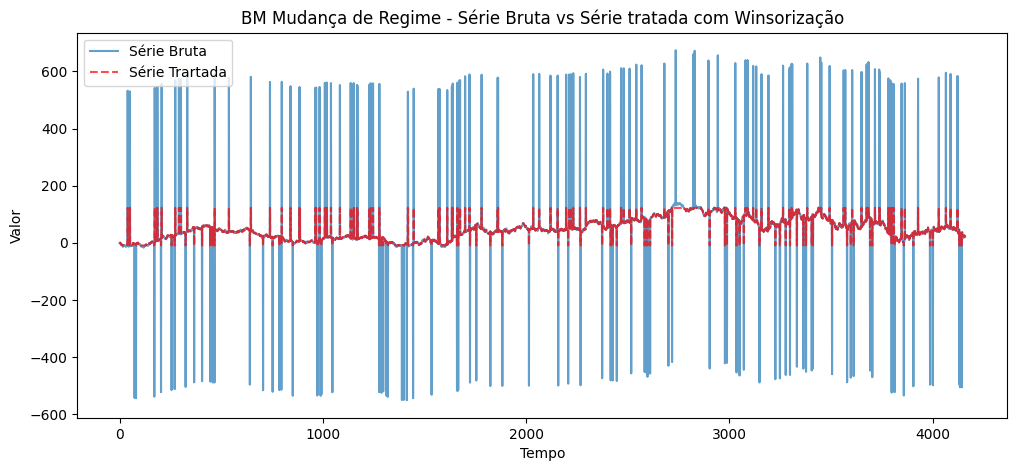

In [14]:
# Comparação entre as séries geradas (séries brutas vs séries tratadas)
plt.figure(figsize=(12, 5))
plt.plot(df_train['regime_switching_1'], label='Série Bruta', alpha=0.7)
plt.plot(df_processed['regime_switching_1_W'], label='Série Trartada', alpha=0.7, linestyle='dashed', color='red')
plt.legend()
plt.title("BM Mudança de Regime - Série Bruta vs Série tratada com Winsorização")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()

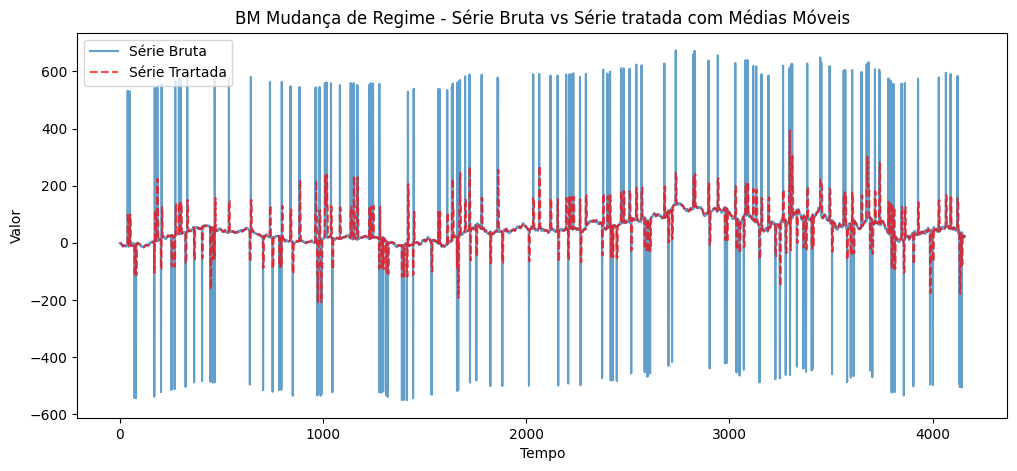

In [15]:
# Comparação entre as séries geradas (séries brutas vs séries tratadas)
plt.figure(figsize=(12, 5))
plt.plot(df_train['regime_switching_1'], label='Série Bruta', alpha=0.7)
plt.plot(df_processed['regime_switching_1_MA'], label='Série Trartada', alpha=0.7, linestyle='dashed', color='red')
plt.legend()
plt.title("BM Mudança de Regime - Série Bruta vs Série tratada com Médias Móveis")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()

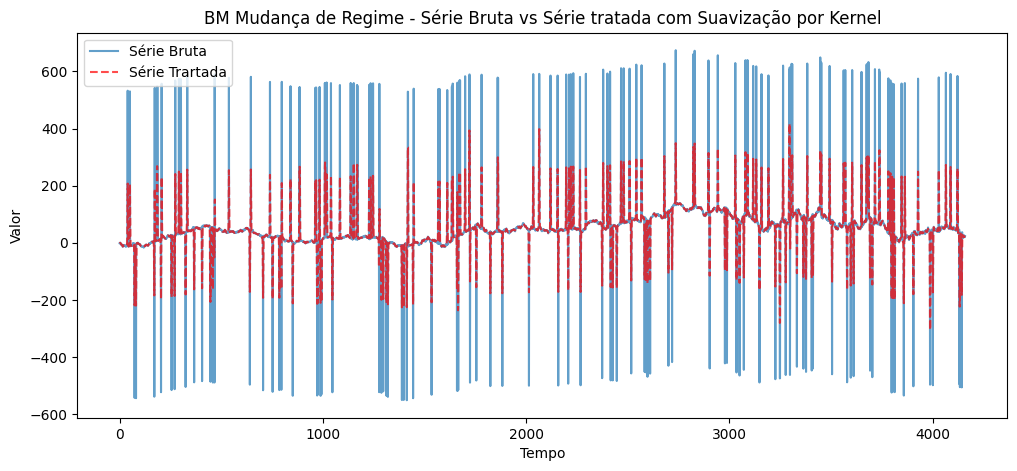

In [16]:
# Comparação entre as séries geradas (séries brutas vs séries tratadas)
plt.figure(figsize=(12, 5))
plt.plot(df_train['regime_switching_1'], label='Série Bruta', alpha=0.7)
plt.plot(df_processed['regime_switching_1_KS'], label='Série Trartada', alpha=0.7, linestyle='dashed', color='red')
plt.legend()
plt.title("BM Mudança de Regime - Série Bruta vs Série tratada com Suavização por Kernel")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()

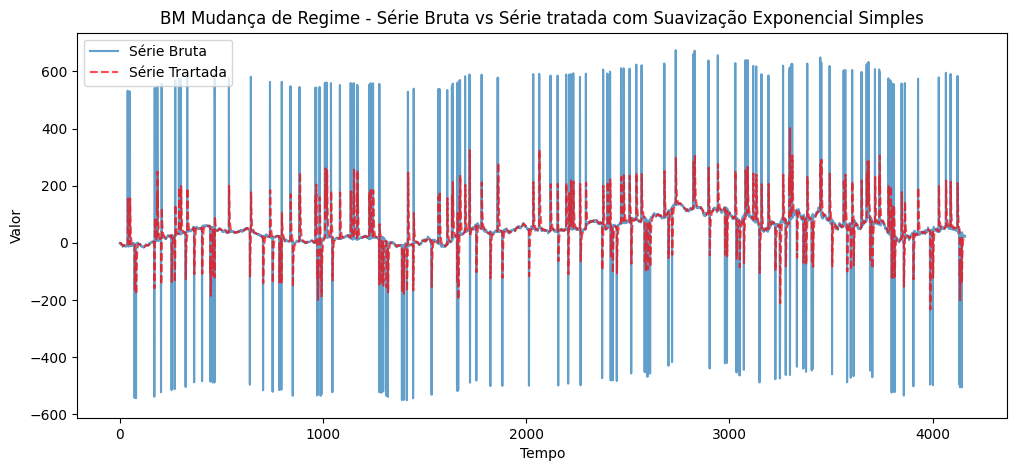

In [17]:
# Comparação entre as séries geradas (séries brutas vs séries tratadas)
plt.figure(figsize=(12, 5))
plt.plot(df_train['regime_switching_1'], label='Série Bruta', alpha=0.7)
plt.plot(df_processed['regime_switching_1_SES'], label='Série Trartada', alpha=0.7, linestyle='dashed', color='red')
plt.legend()
plt.title("BM Mudança de Regime - Série Bruta vs Série tratada com Suavização Exponencial Simples")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()

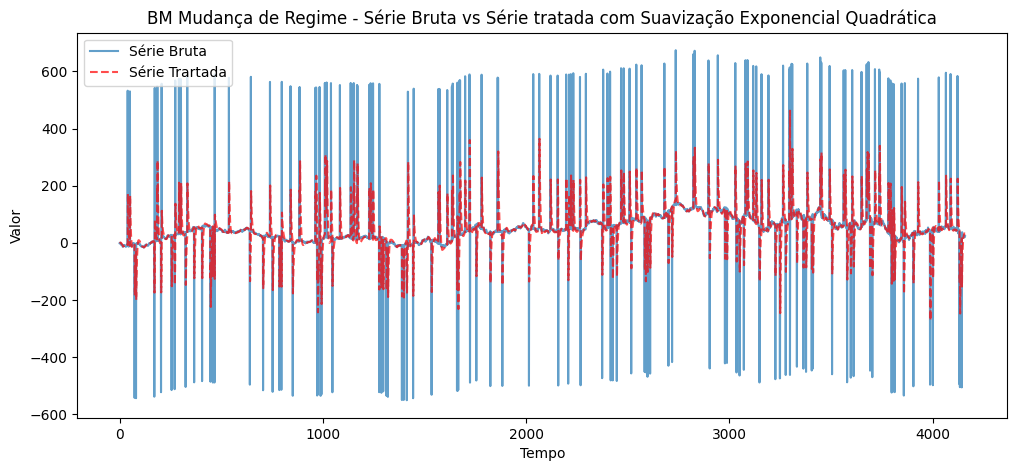

In [18]:
# Comparação entre as séries geradas (séries brutas vs séries tratadas)
plt.figure(figsize=(12, 5))
plt.plot(df_train['regime_switching_1'], label='Série Bruta', alpha=0.7)
plt.plot(df_processed['regime_switching_1_QES'], label='Série Trartada', alpha=0.7, linestyle='dashed', color='red')
plt.legend()
plt.title("BM Mudança de Regime - Série Bruta vs Série tratada com Suavização Exponencial Quadrática")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()

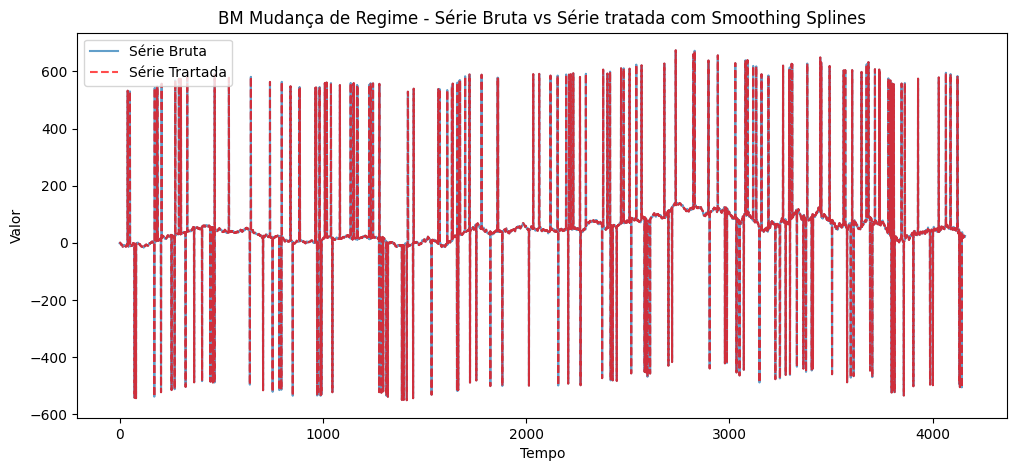

In [19]:
# Comparação entre as séries geradas (séries brutas vs séries tratadas)
plt.figure(figsize=(12, 5))
plt.plot(df_train['regime_switching_1'], label='Série Bruta', alpha=0.7)
plt.plot(df_processed['regime_switching_1_SPLINES'], label='Série Trartada', alpha=0.7, linestyle='dashed', color='red')
plt.legend()
plt.title("BM Mudança de Regime - Série Bruta vs Série tratada com Smoothing Splines")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()

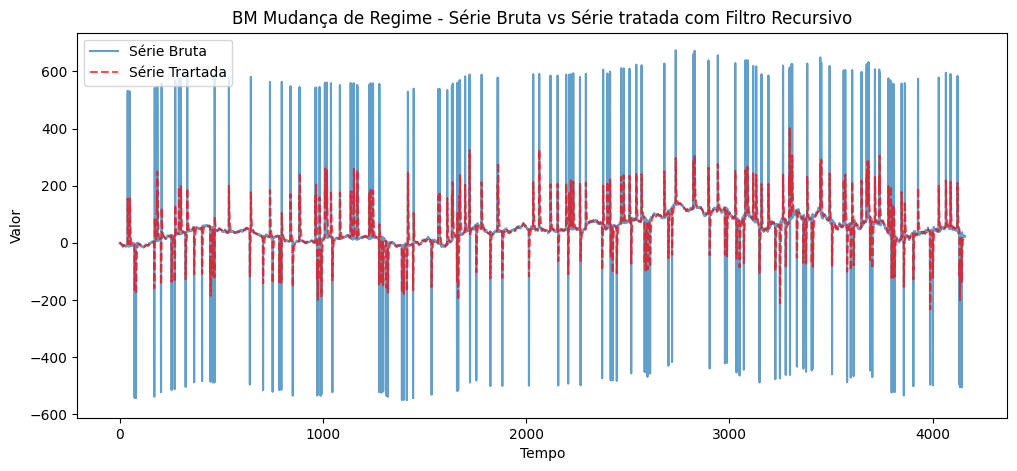

In [20]:
# Comparação entre as séries geradas (séries brutas vs séries tratadas)
plt.figure(figsize=(12, 5))
plt.plot(df_train['regime_switching_1'], label='Série Bruta', alpha=0.7)
plt.plot(df_processed['regime_switching_1_RF'], label='Série Trartada', alpha=0.7, linestyle='dashed', color='red')
plt.legend()
plt.title("BM Mudança de Regime - Série Bruta vs Série tratada com Filtro Recursivo")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()

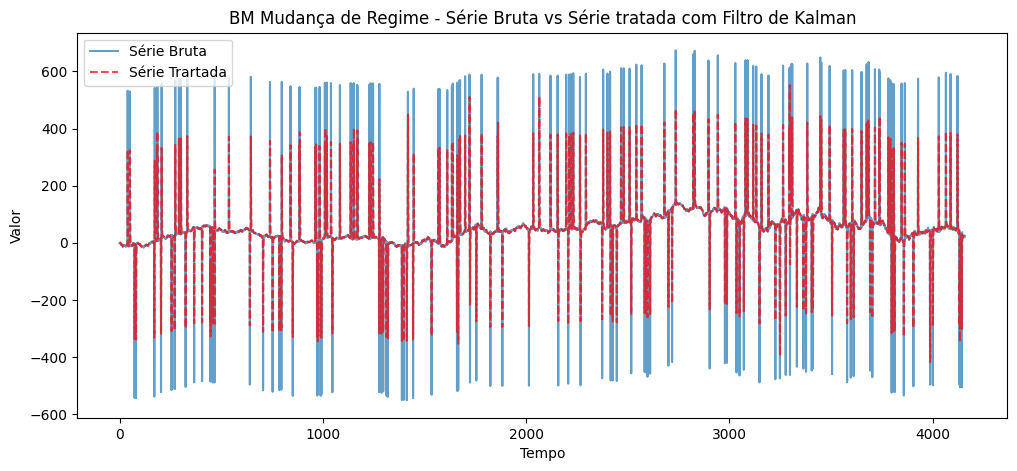

In [21]:
# Comparação entre as séries geradas (séries brutas vs séries tratadas)
plt.figure(figsize=(12, 5))
plt.plot(df_train['regime_switching_1'], label='Série Bruta', alpha=0.7)
plt.plot(df_processed['regime_switching_1_KALMAN'], label='Série Trartada', alpha=0.7, linestyle='dashed', color='red')
plt.legend()
plt.title("BM Mudança de Regime - Série Bruta vs Série tratada com Filtro de Kalman")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()

# 5. Concatenação conjuntos de treino com conjuntos e teste

In [22]:
df_final = pd.DataFrame()
df_final['regime_switching_1_W'] = pd.concat([df_processed['regime_switching_1_W'], df_test['regime_switching_1']], axis=0).to_frame(name="BM_W")
df_final['regime_switching_1_MA'] = pd.concat([df_processed['regime_switching_1_MA'], df_test['regime_switching_1']], axis=0).to_frame(name="BM_MA")
df_final['regime_switching_1_KS'] = pd.concat([df_processed['regime_switching_1_KS'], df_test['regime_switching_1']], axis=0).to_frame(name="BM_KS")
df_final['regime_switching_1_SES'] = pd.concat([df_processed['regime_switching_1_SES'], df_test['regime_switching_1']], axis=0).to_frame(name="BM_SES")
df_final['regime_switching_1_QES'] = pd.concat([df_processed['regime_switching_1_QES'], df_test['regime_switching_1']], axis=0).to_frame(name="BM_QES")
df_final['regime_switching_1_SPLINES'] = pd.concat([df_processed['regime_switching_1_SPLINES'], df_test['regime_switching_1']], axis=0).to_frame(name="BM_SPLINES")
df_final['regime_switching_1_LOWESS'] = pd.concat([df_processed['regime_switching_1_LOWESS'], df_test['regime_switching_1']], axis=0).to_frame(name="BM_LOWESS")
df_final['regime_switching_1_RF'] = pd.concat([df_processed['regime_switching_1_RF'], df_test['regime_switching_1']], axis=0).to_frame(name="BM_RF")
df_final['regime_switching_1_HP'] = pd.concat([df_processed['regime_switching_1_HP'], df_test['regime_switching_1']], axis=0).to_frame(name="BM_HP")
df_final['regime_switching_1_KALMAN'] = pd.concat([df_processed['regime_switching_1_KALMAN'], df_test['regime_switching_1']], axis=0).to_frame(name="BM_KALMAN")
df_final

,regime_switching_1_W,regime_switching_1_MA,regime_switching_1_KS,regime_switching_1_SES,regime_switching_1_QES,regime_switching_1_SPLINES,regime_switching_1_LOWESS,regime_switching_1_RF,regime_switching_1_HP,regime_switching_1_KALMAN
0,-1.687820,NaN,-1.695993,-1.687820,-1.229467,-1.687820,-17.722733,-1.687820,-7.956186,-1.687820
1,-1.229467,NaN,-1.205108,-1.687820,-0.922370,-1.229468,-17.582797,-1.550314,-7.927457,-1.412808
2,-0.830905,NaN,-0.587787,-1.550314,-0.579109,-0.830903,-17.442699,-1.334491,-7.898728,-1.054714
3,0.664868,NaN,-0.129334,-1.334491,-0.226812,0.664865,-17.302440,-0.734684,-7.869997,0.007381
4,-0.226449,-0.661955,-0.349115,-0.734684,0.495278,-0.226446,-17.162018,-0.582213,-7.841263,-0.137121
...,...,...,...,...,...,...,...,...,...,...
5938,-588.370328,-588.370328,-588.370328,-588.370328,-588.370328,-588.370328,-588.370328,-588.370328,-588.370328,-588.370328
5939,-596.097531,-596.097531,-596.097531,-596.097531,-596.097531,-596.097531,-596.097531,-596.097531,-596.097531,-596.097531
5940,-595.566006,-595.566006,-595.566006,-595.566006,-595.566006,-595.566006,-595.566006,-595.566006,-595.566006,-595.566006
5941,-595.597494,-595.597494,-595.597494,-595.597494,-595.597494,-595.597494,-595.597494,-595.597494,-595.597494,-595.597494


# 6. Exportação do dataframe

In [23]:
file_path = '[BM Regime Switching 1] Séries temporais.xlsx'
df_final.to_excel(file_path, index=False)
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>